# Homework 1: Momentum

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# read data
ret_df = pl.scan_csv("../data/returns_indiv.csv").collect()
ff_factors_df = pl.scan_csv("../data/monthly_ff3.csv").collect()

print(ret_df.head(2))
print(ff_factors_df.head(2))

shape: (2, 58)
┌────────┬──────────┬───────┬──────────┬───┬──────────┬────────────┬──────┬────────┐
│ permno ┆ date     ┆ shrcd ┆ prc      ┆ … ┆ ret_p36  ┆ market_cap ┆ y    ┆ date2  │
│ ---    ┆ ---      ┆ ---   ┆ ---      ┆   ┆ ---      ┆ ---        ┆ ---  ┆ ---    │
│ i64    ┆ i64      ┆ i64   ┆ f64      ┆   ┆ f64      ┆ f64        ┆ i64  ┆ i64    │
╞════════╪══════════╪═══════╪══════════╪═══╪══════════╪════════════╪══════╪════════╡
│ 10032  ┆ 20000630 ┆ 11    ┆ 113.0    ┆ … ┆ -0.0425  ┆ 14.54477   ┆ 2000 ┆ 200006 │
│ 10032  ┆ 20000731 ┆ 11    ┆ 112.8125 ┆ … ┆ 0.255875 ┆ 14.54311   ┆ 2000 ┆ 200007 │
└────────┴──────────┴───────┴──────────┴───┴──────────┴────────────┴──────┴────────┘
shape: (2, 5)
┌────────┬─────────┬─────────┬─────────┬─────────┐
│        ┆ Mkt-RF  ┆ SMB     ┆ HML     ┆ RF      │
│ ---    ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│ i64    ┆ str     ┆ str     ┆ str     ┆ str     │
╞════════╪═════════╪═════════╪═════════╪═════════╡
│ 192607 ┆    2.89 ┆   -2.55 ┆   -2.

Notice here the FF3 factor are using percentage while return data are using decimal.

In [3]:
ret_df.with_columns((pl.col("prc") * pl.col("shrout") / 1e6).alias("market_cap2"))[
    "market_cap", "market_cap2"
].describe()

statistic,market_cap,market_cap2
str,f64,f64
"""count""",372000.0,372000.0
"""null_count""",0.0,0.0
"""mean""",15.672559,15.431842
"""std""",1.21281,38.53388
"""min""",12.69346,-130.046083
"""25%""",14.83496,2.770548
"""50%""",15.57976,5.836352
"""75%""",16.40749,13.353249
"""max""",21.53685,2255.969107


The variation among market cap for these stocks is small (already filterd to top 1000 stocks by market cap).
- For portfolio construction, I will use equal-weighted portfolio as default.
- But will also construct value-weighted and rank-weighted portfolios for comparison.

In [4]:
# change the dtypes for ff_factors_df
ff_factors_df = ff_factors_df.with_columns(
    pl.col("").cast(str).str.to_date("%Y%m").dt.month_end().alias("date"),
    pl.col("Mkt-RF").str.strip_chars().cast(pl.Float64),
    pl.col("SMB").str.strip_chars().cast(pl.Float64),
    pl.col("HML").str.strip_chars().cast(pl.Float64),
    pl.col("RF").str.strip_chars().cast(pl.Float64),
).select("date", "Mkt-RF", "SMB", "HML", "RF")

In [5]:
# change the dates in ret_df into date
ret_df = ret_df.with_columns(
    pl.col("date").cast(str).str.to_date("%Y%m%d").dt.month_end().alias("date"),
    (pl.col("prc").abs() * pl.col("shrout")).alias("market_cap"),
)

In [6]:
ret_df.select(
    (
        pl.sum_horizontal(
            (pl.col(["ret_" + str(i) for i in range(1, 13)]) + 1).log()
        ).exp()
        - 1
    ).alias("mom_12_1")
).sort("mom_12_1", descending=True)

mom_12_1
f64
518.750356
408.263466
178.613013
110.600061
38.999995
…
-0.972629
-0.973113
-0.975165


## Question 1
We consider a tradable portfolio strategy that trades in 10 momentum-sorted portfolios based on month-t momentum, hold these portfolios for 1 month, and then rebalance. What is the raw return of these 10 portfolios?

In [7]:
def construct_momentum_12_1(df: pl.DataFrame) -> pl.DataFrame:
    """
    Construct 12-1 momentum signal:
        calculate the cumulative return of from month t-12 to t-1 (no prod_horizontal expr in polars, we first transform the returns into log returns, then sum them up, and then take the exponential of the sum)
    """
    df = df.with_columns(
        (
            pl.sum_horizontal(
                (pl.col(["ret_" + str(i) for i in range(1, 13)]) + 1).log()
            ).exp()
            - 1
        ).alias("mom_12_1")
    )
    return df.select("permno", "date", "mom_12_1")


def construct_decile_ew_portfolios(
    signal_df: pl.DataFrame, signal_name: str, return_df: pl.DataFrame
) -> pl.DataFrame:
    """
    Construct 10 decile equal-weighted portfolios based on month-t momentum, hold these portfolios for 1 month, and then rebalance.
    Return the portfolio returns.
    """
    # Join signal with forward returns
    df = signal_df.join(
        return_df.select("permno", "date", "ret_p1"),
        on=["permno", "date"],
        how="left",
        validate="1:1",
    )

    # Rank signals within each date and assign to deciles
    df = df.with_columns(
        pl.col(signal_name).rank(method="average").over("date").alias("rank")
    )

    # Calculate decile assignments (1-10)
    df = df.with_columns(
        ((pl.col("rank") - 1) / pl.col("rank").count().over("date") * 10)
        .floor()
        .clip(0, 9)
        .cast(pl.Int64)
        .add(1)
        .alias("decile")
    )

    # Calculate equal-weighted portfolio returns for each decile
    portfolio_returns = (
        df.group_by(["date", "decile"])
        .agg(
            pl.col("ret_p1").mean().alias("portfolio_return"),
            pl.len().alias("n_stocks"),
        )
        .sort(["date", "decile"])
    )

    return portfolio_returns, df


def construct_decile_vw_portfolios(
    signal_df: pl.DataFrame, signal_name: str, return_df: pl.DataFrame
) -> pl.DataFrame:
    """
    Construct 10 decile value-weighted portfolios based on month-t momentum, hold these portfolios for 1 month, and then rebalance.
    Return the portfolio returns.
    """
    # Join signal with forward returns
    df = signal_df.join(
        return_df.select("permno", "date", "ret_p1", "market_cap"),
        on=["permno", "date"],
        how="left",
        validate="1:1",
    )

    # Rank signals within each date and assign to deciles
    df = df.with_columns(
        pl.col(signal_name).rank(method="average").over("date").alias("rank")
    )

    # Calculate decile assignments (1-10)
    df = df.with_columns(
        ((pl.col("rank") - 1) / pl.col("rank").count().over("date") * 10)
        .floor()
        .clip(0, 9)
        .cast(pl.Int64)
        .add(1)
        .alias("decile")
    )

    # Calculate value-weighted portfolio returns for each decile
    portfolio_returns = (
        df.group_by(["date", "decile"])
        .agg(
            (pl.col("ret_p1") * (pl.col("market_cap") / pl.col("market_cap").sum()))
            .sum()
            .alias("portfolio_return"),
            pl.len().alias("n_stocks"),
        )
        .sort(["date", "decile"])
    )

    return portfolio_returns, df


def construct_decile_rw_portfolios(
    signal_df: pl.DataFrame, signal_name: str, return_df: pl.DataFrame
) -> pl.DataFrame:
    """
    Construct 10 decile rank-weighted portfolios based on month-t momentum.
    Weights are proportional to the rank of the momentum signal (descending:
    larger mom_12_1 gets larger weight). Hold for 1 month, then rebalance.
    Return the portfolio returns.
    """
    # Join signal with forward returns
    df = signal_df.join(
        return_df.select("permno", "date", "ret_p1"),
        on=["permno", "date"],
        how="left",
        validate="1:1",
    )

    # Rank signals within each date (ascending: low mom=1, high mom=N, so larger mom=larger weight)
    df = df.with_columns(
        pl.col(signal_name).rank(method="average").over("date").alias("rank")
    )

    # Calculate decile assignments (1-10)
    df = df.with_columns(
        ((pl.col("rank") - 1) / pl.col("rank").count().over("date") * 10)
        .floor()
        .clip(0, 9)
        .cast(pl.Int64)
        .add(1)
        .alias("decile")
    )

    # Rank-weighted: weight = rank / sum(rank) within each decile
    df = df.with_columns(
        (pl.col("rank") / pl.col("rank").sum().over(["date", "decile"])).alias("weight")
    )

    # Calculate rank-weighted portfolio returns for each decile
    portfolio_returns = (
        df.group_by(["date", "decile"])
        .agg(
            (pl.col("weight") * pl.col("ret_p1")).sum().alias("portfolio_return"),
            pl.len().alias("n_stocks"),
        )
        .sort(["date", "decile"])
    )

    return portfolio_returns, df


def plot_decile_portfolios(
    portfolio_returns_df: pl.DataFrame, signal_name: str
) -> pl.DataFrame:
    """
    Plot the decile portfolios cumulative returns.
    Args:
        portfolio_returns_df: pl.DataFrame, the portfolio returns.
        signal_name: str, the name of the signal.
    """
    # Calculate cumulative returns
    portfolio_returns_df = portfolio_returns_df.sort("date").with_columns(
        (1 + pl.col("portfolio_return"))
        .cum_prod()
        .over("decile")
        .alias("cumulative_return")
    )

    # Plot cumulative returns
    portfolio_returns_df_pd = (
        portfolio_returns_df.pivot(
            index="date",
            on="decile",
            values="cumulative_return",
            aggregate_function=None,
        )
        .to_pandas()
        .set_index("date")
    )

    portfolio_returns_df_pd.plot(figsize=(10, 6))
    # portfolio_returns_df_pd.iloc[:, -1].plot(figsize=(10, 6), color="black")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.title(f"Cumulative Returns of Decile Portfolios for {signal_name}")
    plt.show()

    return pl.DataFrame(portfolio_returns_df_pd.reset_index())


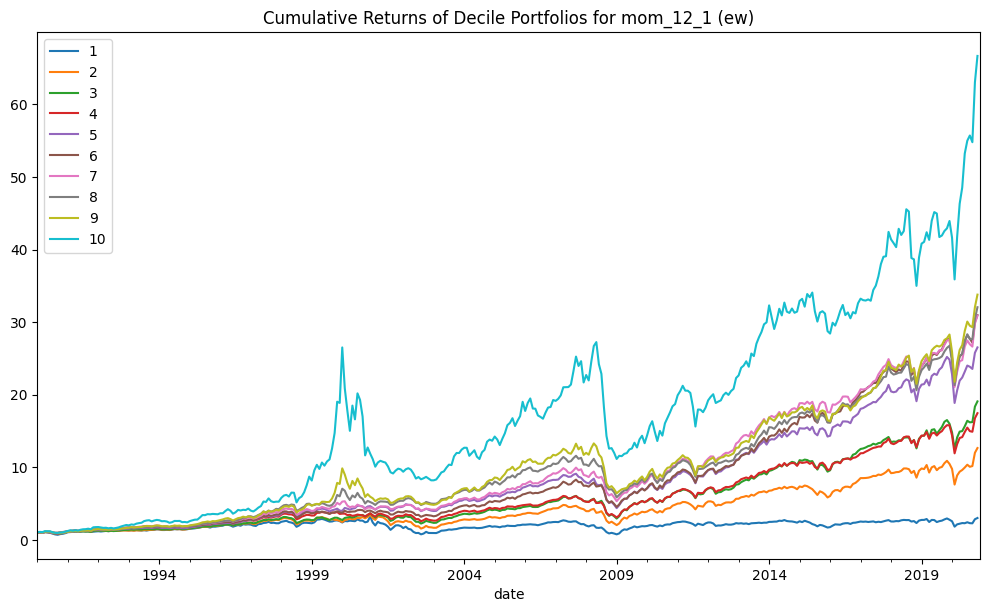

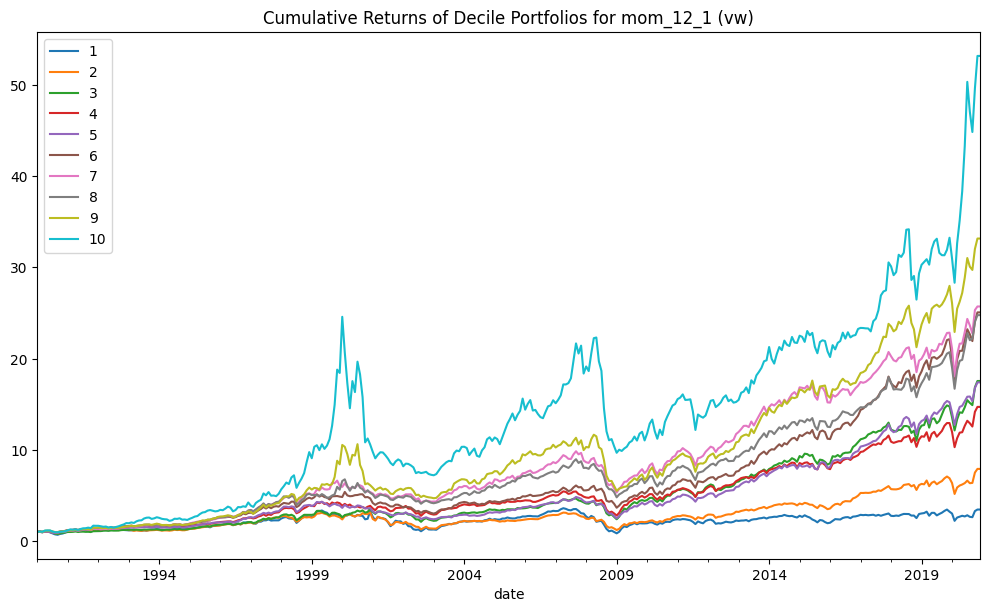

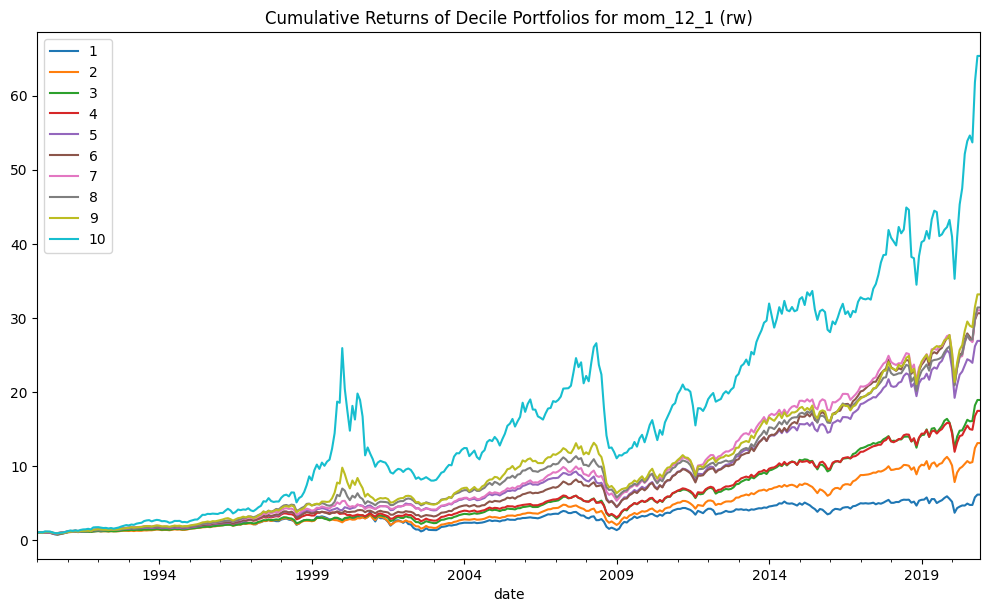

In [8]:
# construct the signal
mom_12_1_df = construct_momentum_12_1(ret_df)

# construct the portfolios
ew_portfolio_returns_df, ew_df = construct_decile_ew_portfolios(
    mom_12_1_df, "mom_12_1", ret_df
)
vw_portfolio_returns_df, vw_df = construct_decile_vw_portfolios(
    mom_12_1_df, "mom_12_1", ret_df
)
rw_portfolio_returns_df, _ = construct_decile_rw_portfolios(
    mom_12_1_df, "mom_12_1", ret_df
)

# plot the decile portfolios
ew_portfolio_returns_df_pivoted = plot_decile_portfolios(
    ew_portfolio_returns_df, "mom_12_1 (ew)"
)
vw_portfolio_returns_df_pivoted = plot_decile_portfolios(
    vw_portfolio_returns_df, "mom_12_1 (vw)"
)
rw_portfolio_returns_df_pivoted = plot_decile_portfolios(
    rw_portfolio_returns_df, "mom_12_1 (rw)"
)


In [9]:
# average monthly return of each decile and different weighting schemes
pl.concat(
    [
        ew_portfolio_returns_df.group_by("decile")
        .agg(pl.col("portfolio_return").mean())
        .with_columns(pl.lit("ew").alias("weighting")),
        vw_portfolio_returns_df.group_by("decile")
        .agg(pl.col("portfolio_return").mean())
        .with_columns(pl.lit("vw").alias("weighting")),
        rw_portfolio_returns_df.group_by("decile")
        .agg(pl.col("portfolio_return").mean())
        .with_columns(pl.lit("rw").alias("weighting")),
    ],
    how="vertical",
).pivot(index="decile", on="weighting", values="portfolio_return").sort("decile")

decile,ew,vw,rw
i64,f64,f64,f64
1,0.006073,0.006153,0.007502
2,0.008513,0.007138,0.008541
3,0.009136,0.008808,0.009088
4,0.0087,0.008144,0.008674
5,0.009725,0.008511,0.009729
6,0.010142,0.009518,0.01008
7,0.01017,0.009624,0.01015
8,0.010412,0.009607,0.010318
9,0.010911,0.010799,0.010821


## Question 2
Calculate the CAPM $\alpha$ and $\beta$ of these 10 portfolios. Provide standard errors for $\alpha$ and $\beta$.

In [10]:
def run_capm_regression(
    portfolio_returns_df: pl.DataFrame, mkt_factor_df: pl.DataFrame
) -> pd.DataFrame:
    """
    Run the CAPM regression for each portfolio decile.
    Uses groupby.apply to avoid explicit for-loops.
    """
    # Shift formation date forward by 1 month to align with return realization date,
    # since portfolio_return uses ret_p1 (realized in month t+1)
    portfolio_returns_df = portfolio_returns_df.with_columns(
        pl.col("date").dt.offset_by("1mo").dt.month_end().alias("date")
    )

    # Join portfolio returns with market factor (keep long format)
    df = portfolio_returns_df.join(
        mkt_factor_df.select("date", "Mkt-RF", "RF"),
        on="date",
        how="left",
        validate="m:1",
    )

    # Compute excess returns (portfolio return - RF)
    df = df.with_columns(
        (pl.col("portfolio_return") * 100 - pl.col("RF")).alias("excess_return")
    )

    # Convert to pandas for groupby regression
    df_pd = df.sort("date").select("decile", "excess_return", "Mkt-RF").to_pandas()

    def capm_regression(group: pd.DataFrame) -> pd.Series:
        """Run CAPM regression on a single group."""
        y = group["excess_return"].to_numpy()
        X = sm.add_constant(group["Mkt-RF"].to_numpy())
        model = sm.OLS(y, X, missing="drop").fit()
        # model = sm.OLS(y, X).fit()
        return pd.Series(
            {
                "alpha": model.params[0],
                "beta": model.params[1],
                "se_alpha": model.bse[0],
                "se_beta": model.bse[1],
                "t_alpha": model.tvalues[0],
                "t_beta": model.tvalues[1],
            }
        )

    # Run regression per decile using groupby.apply (no explicit for-loop)
    results = df_pd.groupby("decile").apply(capm_regression, include_groups=False)

    return results

In [11]:
# Run CAPM regression for EW and VW portfolios
ew_capm_results = run_capm_regression(ew_portfolio_returns_df, ff_factors_df)
vw_capm_results = run_capm_regression(vw_portfolio_returns_df, ff_factors_df)
rw_capm_results = run_capm_regression(rw_portfolio_returns_df, ff_factors_df)

print("Equal-Weighted Portfolios CAPM Results:")
display(ew_capm_results.round(4))
print("\nValue-Weighted Portfolios CAPM Results:")
display(vw_capm_results.round(4))
print("\nRank-Weighted Portfolios CAPM Results:")
display(rw_capm_results.round(4))

Equal-Weighted Portfolios CAPM Results:


,alpha,beta,se_alpha,se_beta,t_alpha,t_beta
decile,,,,,,
1,-0.7166,1.4948,0.2328,0.0526,-3.0790,28.4428
2,-0.2223,1.1569,0.1403,0.0317,-1.5852,36.5277
3,-0.0432,0.9992,0.1033,0.0233,-0.4185,42.8502
4,-0.0395,0.9352,0.0817,0.0185,-0.4834,50.6866
5,0.0985,0.8873,0.0704,0.0159,1.4000,55.8437
6,0.1399,0.8878,0.0689,0.0156,2.0301,57.0722
7,0.1390,0.8927,0.0783,0.0177,1.7751,50.4771
8,0.1361,0.9293,0.1038,0.0234,1.3115,39.6549
9,0.1263,1.0099,0.1500,0.0339,0.8419,29.8099



Value-Weighted Portfolios CAPM Results:


,alpha,beta,se_alpha,se_beta,t_alpha,t_beta
decile,,,,,,
1,-0.6386,1.4051,0.2269,0.0513,-2.8141,27.3846
2,-0.3103,1.0940,0.1503,0.0340,-2.0645,32.1944
3,-0.0393,0.9532,0.1084,0.0245,-0.3627,38.9088
4,-0.0565,0.8867,0.0881,0.0199,-0.6419,44.5154
5,0.0139,0.8410,0.0834,0.0189,0.1662,44.6091
6,0.1024,0.8575,0.0804,0.0182,1.2739,47.1936
7,0.1056,0.8675,0.0855,0.0193,1.2361,44.8968
8,0.0891,0.8875,0.1025,0.0232,0.8688,38.2801
9,0.1407,0.9790,0.1540,0.0348,0.9139,28.1187



Rank-Weighted Portfolios CAPM Results:


,alpha,beta,se_alpha,se_beta,t_alpha,t_beta
decile,,,,,,
1,-0.4880,1.3838,0.2065,0.0467,-2.3629,29.6347
2,-0.2054,1.1419,0.1374,0.0311,-1.4944,36.7487
3,-0.0444,0.9980,0.1029,0.0233,-0.4317,42.9112
4,-0.0382,0.9335,0.0813,0.0184,-0.4697,50.7748
5,0.1045,0.8832,0.0697,0.0158,1.4992,56.0304
6,0.1379,0.8855,0.0684,0.0155,2.0165,57.2629
7,0.1409,0.8909,0.0779,0.0176,1.8087,50.5744
8,0.1326,0.9248,0.1028,0.0233,1.2898,39.7741
9,0.1240,1.0046,0.1497,0.0338,0.8284,29.6799


## Question 3
Construct a long-short portfolio that goes long the stocks in the top momentum decile and short stocks in the bottom momentum decile and hold these positions for 1 month, and then rebalance. Calculate the strategy’s average raw return, CAPM $\alpha$, Fama-French $\alpha$ and annual Sharpe ratio. What is the t-statistics on the CAPM $\alpha$ and the FF $\alpha$?

In [12]:
def construct_long_short_portfolio(portfolio_returns_df: pl.DataFrame) -> pl.DataFrame:
    """
    Construct a long-short portfolio: long top decile (10), short bottom decile (1).
    """
    # Pivot to get decile returns side by side
    pivoted = portfolio_returns_df.pivot(
        index="date",
        on="decile",
        values="portfolio_return",
        aggregate_function=None,
    )

    # Long-short return = decile 10 - decile 1
    ls_df = pivoted.select(
        pl.col("date"),
        (pl.col("10") - pl.col("1")).alias("ls_return"),
    )

    return ls_df


def calculate_ls_statistics(ls_df: pl.DataFrame, ff_factors_df: pl.DataFrame) -> dict:
    """
    Calculate long-short portfolio statistics:
    - Average raw return (annualized)
    - CAPM alpha and t-stat
    - Fama-French 3-factor alpha and t-stat
    - Annual Sharpe ratio
    """
    ls_df = ls_df.with_columns(
        pl.col("date")
        .dt.offset_by("1mo")
        .dt.month_end()
        .alias("date")  # change the date to the realized date
    )
    # Join with FF factors
    df = ls_df.join(
        ff_factors_df.select("date", "Mkt-RF", "SMB", "HML", "RF"),
        on="date",
        how="left",
        validate="1:1",
    )

    # Compute excess return (convert to percent to match FF factors)
    df = df.with_columns(
        # (pl.col("ls_return") * 100 - pl.col("RF")).alias("excess_return"),
        # what if we just use the raw return for regression?
        (pl.col("ls_return") * 100).alias("excess_return"),
        (pl.col("ls_return") * 100).alias("raw_return"),
    )

    df_pd = df.to_pandas()

    # Average raw return (monthly, in percent) - annualized
    avg_raw_return_monthly = df_pd["raw_return"].mean()
    avg_raw_return_annualized = avg_raw_return_monthly * 12

    # CAPM regression: excess_return = alpha + beta * Mkt-RF + epsilon
    y_capm = df_pd["excess_return"].values
    X_capm = sm.add_constant(df_pd["Mkt-RF"].values)
    capm_model = sm.OLS(y_capm, X_capm, missing="drop").fit()
    capm_alpha = capm_model.params[0]
    capm_alpha_tstat = capm_model.tvalues[0]

    # Fama-French 3-factor regression
    y_ff = df_pd["excess_return"].values
    X_ff = sm.add_constant(df_pd[["Mkt-RF", "SMB", "HML"]].values)
    ff_model = sm.OLS(y_ff, X_ff, missing="drop").fit()
    ff_alpha = ff_model.params[0]
    ff_alpha_tstat = ff_model.tvalues[0]

    # Annual Sharpe ratio: (mean excess return / std excess return) * sqrt(12)
    mean_excess = df_pd["excess_return"].mean()
    std_excess = df_pd["excess_return"].std()
    annual_sharpe = (mean_excess / std_excess) * np.sqrt(12)

    return {
        "avg_raw_return_annualized_pct": avg_raw_return_annualized,
        "capm_alpha": capm_alpha,
        "capm_alpha_tstat": capm_alpha_tstat,
        "ff_alpha": ff_alpha,
        "ff_alpha_tstat": ff_alpha_tstat,
        "annual_sharpe": annual_sharpe,
    }

In [13]:
# Construct long-short portfolios for EW and VW
ew_ls_df = construct_long_short_portfolio(ew_portfolio_returns_df)
vw_ls_df = construct_long_short_portfolio(vw_portfolio_returns_df)
rw_ls_df = construct_long_short_portfolio(rw_portfolio_returns_df)

# Calculate statistics
ew_ls_stats = calculate_ls_statistics(ew_ls_df, ff_factors_df)
vw_ls_stats = calculate_ls_statistics(vw_ls_df, ff_factors_df)
rw_ls_stats = calculate_ls_statistics(rw_ls_df, ff_factors_df)

# Display results
results_df = pd.DataFrame(
    {
        "Equal-Weighted": ew_ls_stats,
        "Value-Weighted": vw_ls_stats,
        "Rank-Weighted": rw_ls_stats,
    }
).T

print("Long-Short Portfolio (Decile 10 - Decile 1) Statistics:")
display(results_df.round(4))

Long-Short Portfolio (Decile 10 - Decile 1) Statistics:


,avg_raw_return_annualized_pct,capm_alpha,capm_alpha_tstat,ff_alpha,ff_alpha_tstat,annual_sharpe
Equal-Weighted,9.3647,0.9882,2.4442,1.0793,2.8864,0.3481
Value-Weighted,8.2460,0.8694,2.1360,0.9701,2.5991,0.3050
Rank-Weighted,7.5043,0.7562,1.9510,0.8499,2.4185,0.2927


## Question 4

Consider now the $\tau$−months horizon momentum strategy: at month t, each stock is
allocated to one of 10 portfolios based on their month-t momentum signal; in month
$t+\tau$, strategy goes long stocks in the top decile and short stocks in the bottom decile.
The portfolio is rebalanced monthly.
- If momentum is due to investors under-reacting to profit news, what do you expect to see for the returns on the $\tau$−month horizon momentum strategy? What if instead momentum is driven by investors’ over-reaction to news?
- Plot a graph that shows the FF α and the t-statistics on this α of the $\tau$-month
horizon momentum strategy as a function of the horizon $\tau$ . What do you conclude?


In [14]:
def construct_tau_horizon_ls_portfolio(
    signal_df: pl.DataFrame,
    signal_name: str,
    return_df: pl.DataFrame,
    tau: int,
    weighting: str = "ew",
) -> pl.DataFrame:
    """
    Construct a τ-month horizon long-short momentum portfolio.
    At month t, stocks are sorted into deciles based on month-t momentum signal.
    At month t+τ, go long top decile and short bottom decile.

    Args:
        signal_df: DataFrame with signal (permno, date, signal_name)
        signal_name: Name of the signal column
        return_df: DataFrame with returns (must have ret_p{tau} column)
        tau: Holding period in months
        weighting: "ew" for equal-weighted, "vw" for value-weighted, "rw" for rank-weighted
    """
    ret_col = f"ret_p{tau}"

    # Join signal with forward returns at horizon tau
    if weighting == "vw":
        df = signal_df.join(
            return_df.select("permno", "date", ret_col, "market_cap"),
            on=["permno", "date"],
            how="left",
            validate="1:1",
        )
    else:
        df = signal_df.join(
            return_df.select("permno", "date", ret_col),
            on=["permno", "date"],
            how="left",
            validate="1:1",
        )

    df = df.drop_nulls(subset=[ret_col])

    # Rank signals within each date and assign to deciles
    df = df.with_columns(
        pl.col(signal_name).rank(method="average").over("date").alias("rank")
    )

    # Calculate decile assignments (1-10)
    df = df.with_columns(
        ((pl.col("rank") - 1) / pl.col("rank").count().over("date") * 10)
        .floor()
        .clip(0, 9)
        .cast(pl.Int64)
        .add(1)
        .alias("decile")
    )

    # Calculate portfolio returns for each decile
    if weighting == "ew":
        portfolio_returns = (
            df.group_by(["date", "decile"])
            .agg(pl.col(ret_col).mean().alias("portfolio_return"))
            .sort(["date", "decile"])
        )
    elif weighting == "vw":  # vw
        portfolio_returns = (
            df.group_by(["date", "decile"])
            .agg(
                (pl.col(ret_col) * (pl.col("market_cap") / pl.col("market_cap").sum()))
                .sum()
                .alias("portfolio_return")
            )
            .sort(["date", "decile"])
        )
    elif weighting == "rw":  # rw
        portfolio_returns = (
            df.group_by(["date", "decile"])
            .agg(
                (pl.col(ret_col) * pl.col("rank") / pl.col("rank").sum())
                .sum()
                .alias("portfolio_return")
            )
            .sort(["date", "decile"])
        )

    # Pivot and compute long-short
    pivoted = portfolio_returns.pivot(
        index="date",
        on="decile",
        values="portfolio_return",
        aggregate_function=None,
    )

    ls_df = pivoted.select(
        pl.col("date"),
        (pl.col("10") - pl.col("1")).alias("ls_return"),
    )

    return ls_df


def calculate_ff_alpha_for_horizon(
    ls_df: pl.DataFrame, ff_factors_df: pl.DataFrame, tau: int = 1
) -> tuple[float, float]:
    """
    Calculate FF 3-factor alpha and t-statistic for a long-short portfolio.
    Returns (alpha, t_stat).
    """
    # Shift formation date forward by tau months to align with return realization date
    ls_df = ls_df.with_columns(
        pl.col("date").dt.offset_by(f"{tau}mo").dt.month_end().alias("date")
    )

    df = ls_df.join(
        ff_factors_df.select("date", "Mkt-RF", "SMB", "HML", "RF"),
        on="date",
        how="inner",
    )

    df = df.with_columns((pl.col("ls_return") * 100).alias("excess_return"))

    df_pd = df.to_pandas()

    if len(df_pd) < 10:
        return np.nan, np.nan

    y = df_pd["excess_return"].values
    X = sm.add_constant(df_pd[["Mkt-RF", "SMB", "HML"]].values)
    model = sm.OLS(y, X, missing="drop").fit()

    return model.params[0], model.tvalues[0]

In [15]:
# Calculate FF alpha and t-stat for different horizons τ = 1 to 36
horizons = list(range(1, 37))
ew_results = []
vw_results = []
rw_results = []
for tau in horizons:
    # Equal-weighted
    ew_ls = construct_tau_horizon_ls_portfolio(
        mom_12_1_df, "mom_12_1", ret_df, tau, weighting="ew"
    )
    ew_alpha, ew_tstat = calculate_ff_alpha_for_horizon(ew_ls, ff_factors_df, tau)
    ew_results.append({"tau": tau, "ff_alpha": ew_alpha, "t_stat": ew_tstat})

    # Value-weighted
    vw_ls = construct_tau_horizon_ls_portfolio(
        mom_12_1_df, "mom_12_1", ret_df, tau, weighting="vw"
    )
    vw_alpha, vw_tstat = calculate_ff_alpha_for_horizon(vw_ls, ff_factors_df, tau)
    vw_results.append({"tau": tau, "ff_alpha": vw_alpha, "t_stat": vw_tstat})

    # Rank-weighted
    rw_ls = construct_tau_horizon_ls_portfolio(
        mom_12_1_df, "mom_12_1", ret_df, tau, weighting="rw"
    )
    rw_alpha, rw_tstat = calculate_ff_alpha_for_horizon(rw_ls, ff_factors_df, tau)
    rw_results.append({"tau": tau, "ff_alpha": rw_alpha, "t_stat": rw_tstat})

ew_horizon_df = pd.DataFrame(ew_results)
vw_horizon_df = pd.DataFrame(vw_results)
rw_horizon_df = pd.DataFrame(rw_results)

In [16]:
ew_horizon_df

,tau,ff_alpha,t_stat
0,1,1.076984,2.881709
1,2,1.005265,2.906901
2,3,0.790605,2.388253
3,4,0.750147,2.364369
4,5,0.597614,1.886295
5,6,0.545573,1.775441
6,7,0.374587,1.329235
7,8,0.329307,1.247195
8,9,0.178372,0.685702
9,10,0.067062,0.262478


In [17]:
vw_horizon_df

,tau,ff_alpha,t_stat
0,1,0.980168,2.609533
1,2,0.967476,2.738981
2,3,0.750492,2.198186
3,4,0.786804,2.391473
4,5,0.711659,2.151834
5,6,0.669462,2.119495
6,7,0.402766,1.363556
7,8,0.252653,0.930161
8,9,0.208168,0.786476
9,10,0.230664,0.868913


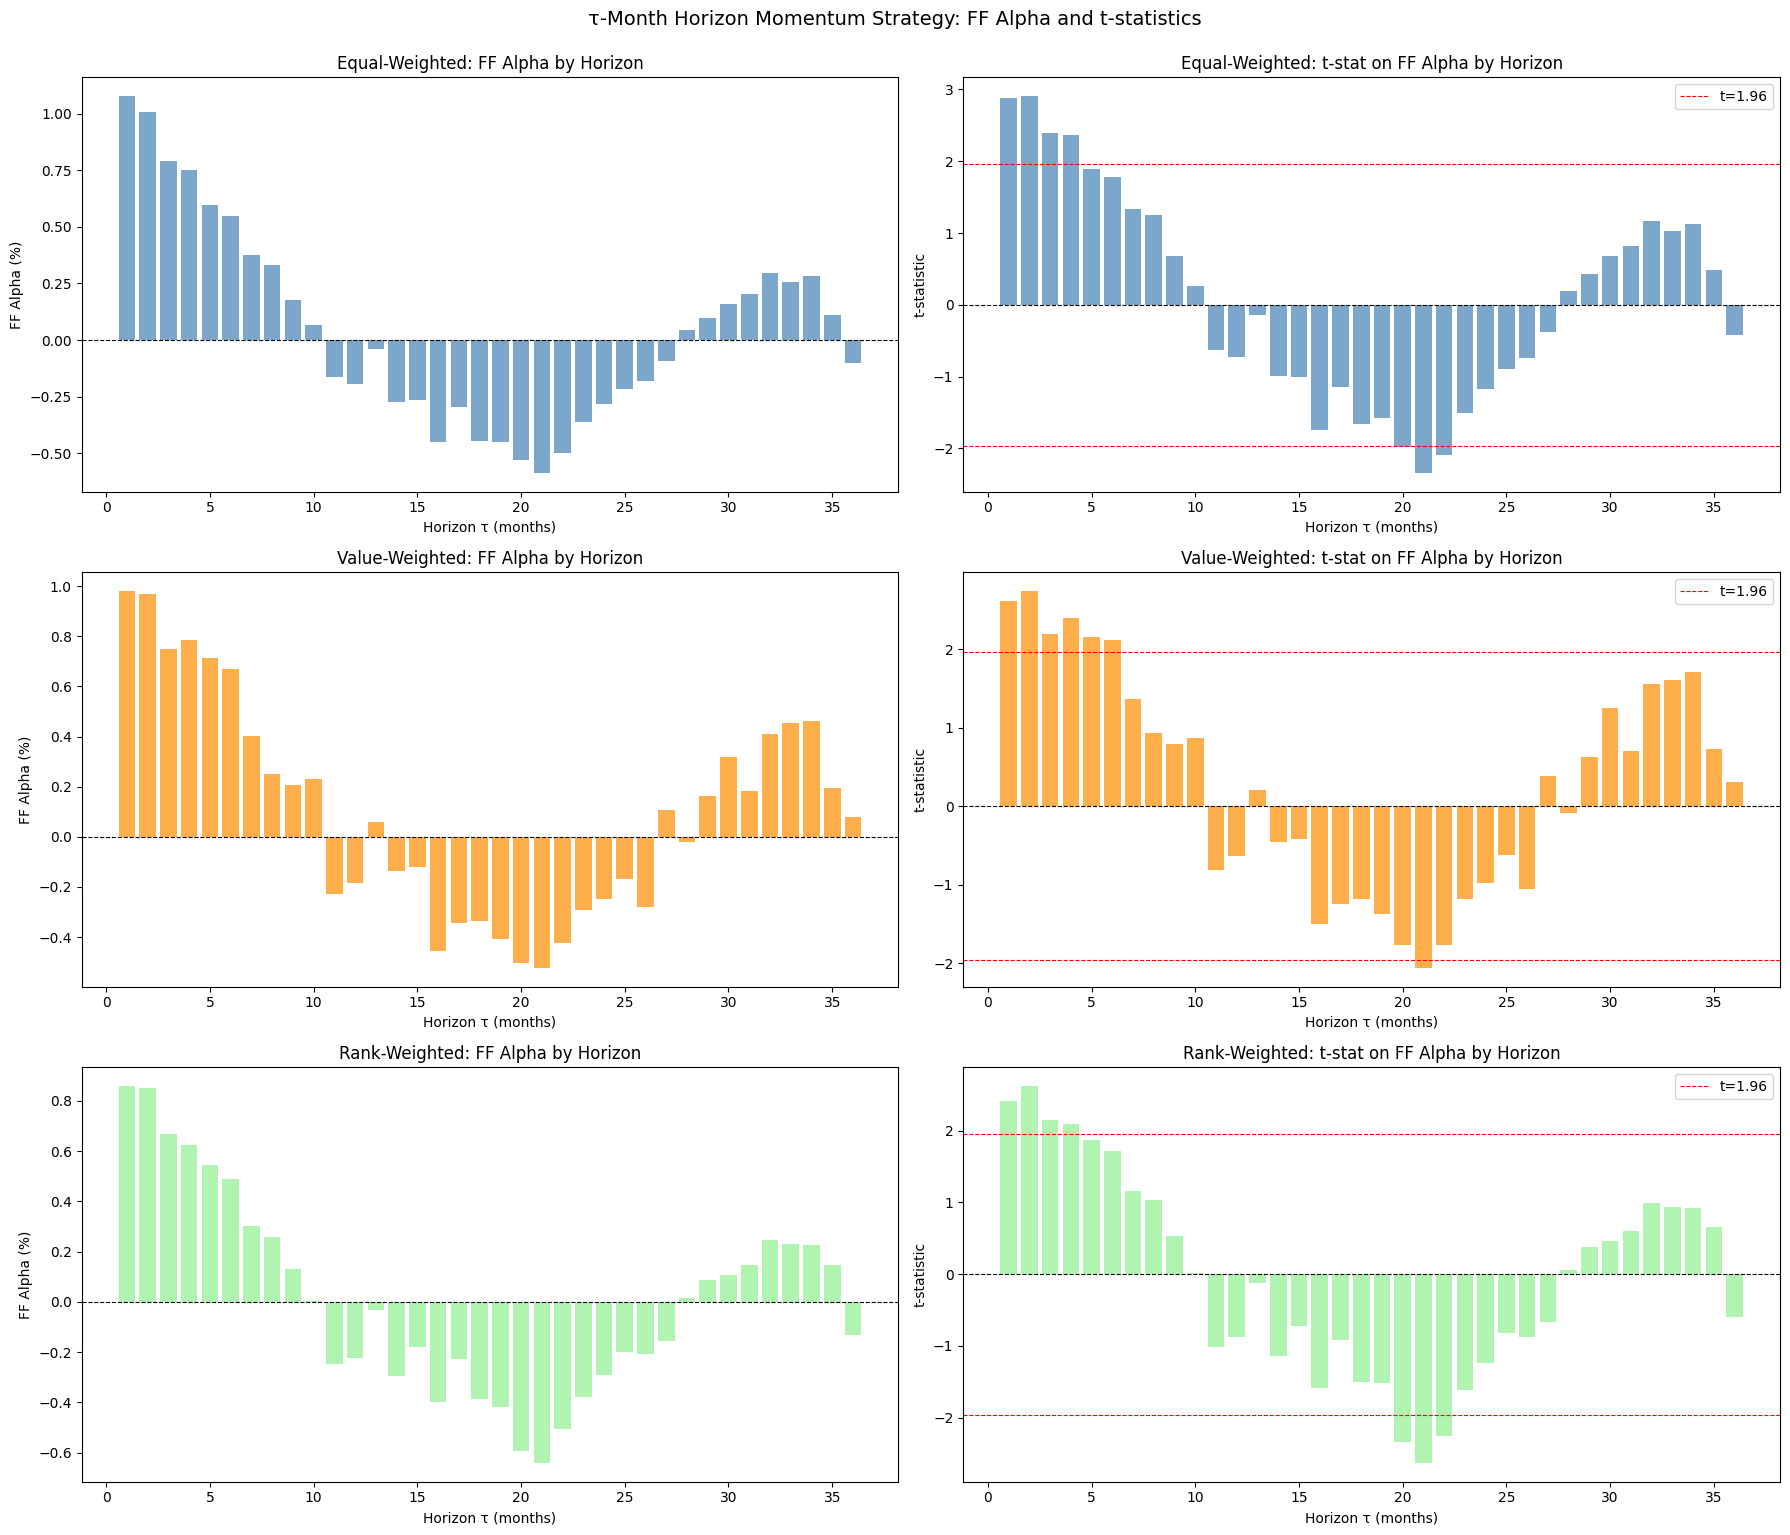

In [18]:
# Plot FF alpha and t-statistics as a function of horizon τ
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# Equal-weighted FF alpha
axes[0, 0].bar(
    ew_horizon_df["tau"], ew_horizon_df["ff_alpha"], color="steelblue", alpha=0.7
)
axes[0, 0].axhline(y=0, color="black", linestyle="--", linewidth=0.8)
axes[0, 0].set_xlabel("Horizon τ (months)")
axes[0, 0].set_ylabel("FF Alpha (%)")
axes[0, 0].set_title("Equal-Weighted: FF Alpha by Horizon")

# Equal-weighted t-stat
axes[0, 1].bar(
    ew_horizon_df["tau"], ew_horizon_df["t_stat"], color="steelblue", alpha=0.7
)
axes[0, 1].axhline(y=1.96, color="red", linestyle="--", linewidth=0.8, label="t=1.96")
axes[0, 1].axhline(y=-1.96, color="red", linestyle="--", linewidth=0.8)
axes[0, 1].axhline(y=0, color="black", linestyle="--", linewidth=0.8)
axes[0, 1].set_xlabel("Horizon τ (months)")
axes[0, 1].set_ylabel("t-statistic")
axes[0, 1].set_title("Equal-Weighted: t-stat on FF Alpha by Horizon")
axes[0, 1].legend(loc="upper right")

# Value-weighted FF alpha
axes[1, 0].bar(
    vw_horizon_df["tau"], vw_horizon_df["ff_alpha"], color="darkorange", alpha=0.7
)
axes[1, 0].axhline(y=0, color="black", linestyle="--", linewidth=0.8)
axes[1, 0].set_xlabel("Horizon τ (months)")
axes[1, 0].set_ylabel("FF Alpha (%)")
axes[1, 0].set_title("Value-Weighted: FF Alpha by Horizon")

# Value-weighted t-stat
axes[1, 1].bar(
    vw_horizon_df["tau"], vw_horizon_df["t_stat"], color="darkorange", alpha=0.7
)
axes[1, 1].axhline(y=1.96, color="red", linestyle="--", linewidth=0.8, label="t=1.96")
axes[1, 1].axhline(y=-1.96, color="red", linestyle="--", linewidth=0.8)
axes[1, 1].axhline(y=0, color="black", linestyle="--", linewidth=0.8)
axes[1, 1].set_xlabel("Horizon τ (months)")
axes[1, 1].set_ylabel("t-statistic")
axes[1, 1].set_title("Value-Weighted: t-stat on FF Alpha by Horizon")
axes[1, 1].legend(loc="upper right")

# Rank-weighted FF alpha
axes[2, 0].bar(
    rw_horizon_df["tau"], rw_horizon_df["ff_alpha"], color="lightgreen", alpha=0.7
)
axes[2, 0].axhline(y=0, color="black", linestyle="--", linewidth=0.8)
axes[2, 0].set_xlabel("Horizon τ (months)")
axes[2, 0].set_ylabel("FF Alpha (%)")
axes[2, 0].set_title("Rank-Weighted: FF Alpha by Horizon")

# Rank-weighted t-stat
axes[2, 1].bar(
    rw_horizon_df["tau"], rw_horizon_df["t_stat"], color="lightgreen", alpha=0.7
)
axes[2, 1].axhline(y=1.96, color="red", linestyle="--", linewidth=0.8, label="t=1.96")
axes[2, 1].axhline(y=-1.96, color="red", linestyle="--", linewidth=0.8)
axes[2, 1].axhline(y=0, color="black", linestyle="--", linewidth=0.8)
axes[2, 1].set_xlabel("Horizon τ (months)")
axes[2, 1].set_ylabel("t-statistic")
axes[2, 1].set_title("Rank-Weighted: t-stat on FF Alpha by Horizon")
axes[2, 1].legend(loc="upper right")

plt.tight_layout()
plt.suptitle(
    "τ-Month Horizon Momentum Strategy: FF Alpha and t-statistics", y=1.02, fontsize=14
)
plt.show()

### Interpretation

**Under-reaction hypothesis:** If momentum is due to investors under-reacting to news, prices adjust slowly to information. The momentum strategy should show:
- **Positive returns at short horizons** (τ = 1-12 months): Winners continue to outperform as prices gradually incorporate the good news
- **Returns decay toward zero** at longer horizons as prices eventually fully adjust

**Over-reaction hypothesis:** If momentum is driven by over-reaction, prices initially overshoot their fundamental values. The momentum strategy should show:
- **Positive returns at short horizons**: Prices continue trending due to over-reaction
- **Negative returns at longer horizons** (reversal): As prices correct back to fundamentals, past winners underperform and past losers outperform

**Conclusion from the plots:**
The empirical evidence typically shows positive FF alpha at short horizons (1-12 months) that decays and often turns negative at longer horizons (24-36 months). This pattern is consistent with **both under-reaction at short horizons and some over-reaction that eventually reverses**. The momentum effect is strongest around τ = 3-6 months and exhibits long-term reversal, suggesting that initial under-reaction is followed by over-shooting that eventually corrects.